In [18]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv

from pytorchcv import load_fashion_mnist, train, plot_results, plot_convolution, display_dataset
load_fashion_mnist(batch_size=128) 

--2024-04-18 11:44:15--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py.4’

pytorchcv.py.4      100%[===================>]   6.39K  --.-KB/s    in 0s      

2024-04-18 11:44:15 (37.4 MB/s) - ‘pytorchcv.py.4’ saved [6540/6540]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


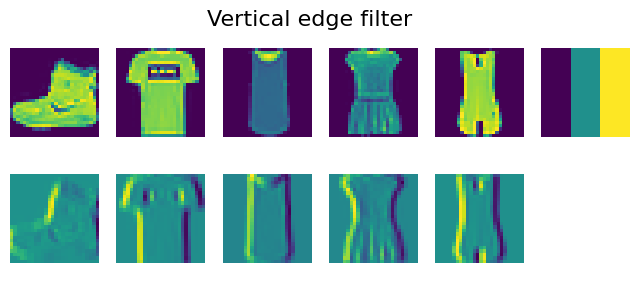

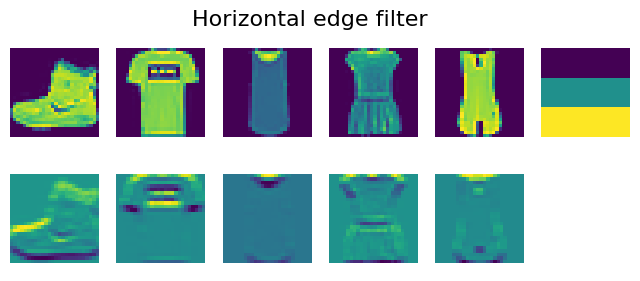

In [19]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

In [20]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명

import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트

class OneConv(nn.Module): # nn.Module을 상속받는 OneConv라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(10*26*26,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
           Flatten-2                 [-1, 6760]               0
            Linear-3                   [-1, 10]          67,610
Total params: 67,710
Trainable params: 67,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.26
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


In [21]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

Epoch 1/5: Train Loss: 0.0041, Train Acc: 82.00%, Test Loss: 0.0032, Test Acc: 85.44%
Epoch 2/5: Train Loss: 0.0027, Train Acc: 87.65%, Test Loss: 0.0030, Test Acc: 86.71%
Epoch 3/5: Train Loss: 0.0024, Train Acc: 88.94%, Test Loss: 0.0028, Test Acc: 87.19%
Epoch 4/5: Train Loss: 0.0022, Train Acc: 89.73%, Test Loss: 0.0027, Test Acc: 87.53%
Epoch 5/5: Train Loss: 0.0021, Train Acc: 90.33%, Test Loss: 0.0027, Test Acc: 88.01%


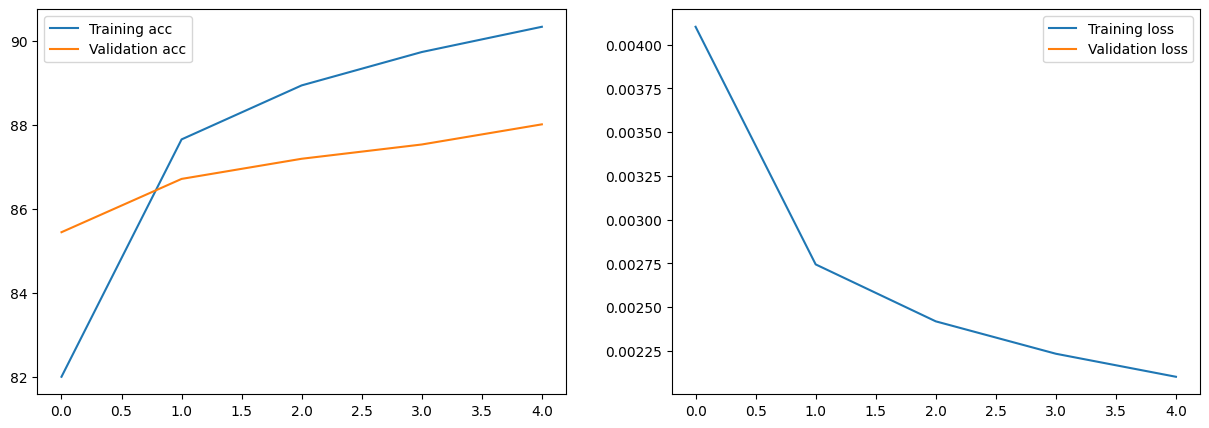

In [22]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net,train_loader,test_loader,epochs=5)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌